In [ ]:
!pip install --upgrade tensorflow-federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 42.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
ERROR:jax._src.xla_bridge:Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/xla_bridge.py", line 438, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/usr/local/lib/python3.10/dist-packages/jax_plugins/xla_cuda12/__init__.py", line 85, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving WSN-DS.csv to WSN-DS.csv


In [ ]:

'''# Load and prepare data
df = pd.read_csv("/content/WSN-DS.csv")
df['Attack_Label'] = df['Attack type']  # Retain original labels
df2 = pd.get_dummies(df["Attack type"], dtype="int64")
df.drop("Attack type", axis=1, inplace=True)
df = pd.concat([df, df2], axis=1)'''
df = pd.read_csv("/content/WSN-DS.csv")


FileNotFoundError: [Errno 2] No such file or directory: '/content/WSN-DS.csv'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot distribution of attack types
plt.figure(figsize=(10, 6))
sns.countplot(df,x="Attack type")
plt.title('Distribution of Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df2 = pd.get_dummies(df["Attack type"], dtype="int64")
df.drop("Attack type", axis=1, inplace=True)

df = pd.concat([df, df2], axis=1)

In [ ]:
df.dtypes

 id                   int64
 Time                 int64
 Is_CH                int64
 who CH               int64
 Dist_To_CH         float64
 ADV_S                int64
 ADV_R                int64
 JOIN_S               int64
 JOIN_R               int64
 SCH_S                int64
 SCH_R                int64
Rank                  int64
 DATA_S               int64
 DATA_R               int64
 Data_Sent_To_BS      int64
 dist_CH_To_BS      float64
 send_code            int64
Expaned Energy      float64
Blackhole             int64
Flooding              int64
Grayhole              int64
Normal                int64
TDMA                  int64
dtype: object

In [ ]:
X = df.iloc[:, :-5]
y = df.iloc[:, -5:]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
'''scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
'''
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled_df=pd.DataFrame(X_train_scaled)
X_train_scaled_df.columns=X.columns


In [ ]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))



In [ ]:
print(X_train_reshaped.shape)
print(X_test_reshaped.shape)

(299728, 18, 1)
(74933, 18, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Lambda
import tensorflow as tf
import collections

In [ ]:
from sklearn.decomposition import PCA
model=PCA(n_components=7).fit(X_train_scaled_df)
post_pca=model.transform(X_train_scaled_df)
n_pcs= model.components_.shape[0]
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names=X_train_scaled_df.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
most_important_names
most_important_names = list(set(most_important_names))

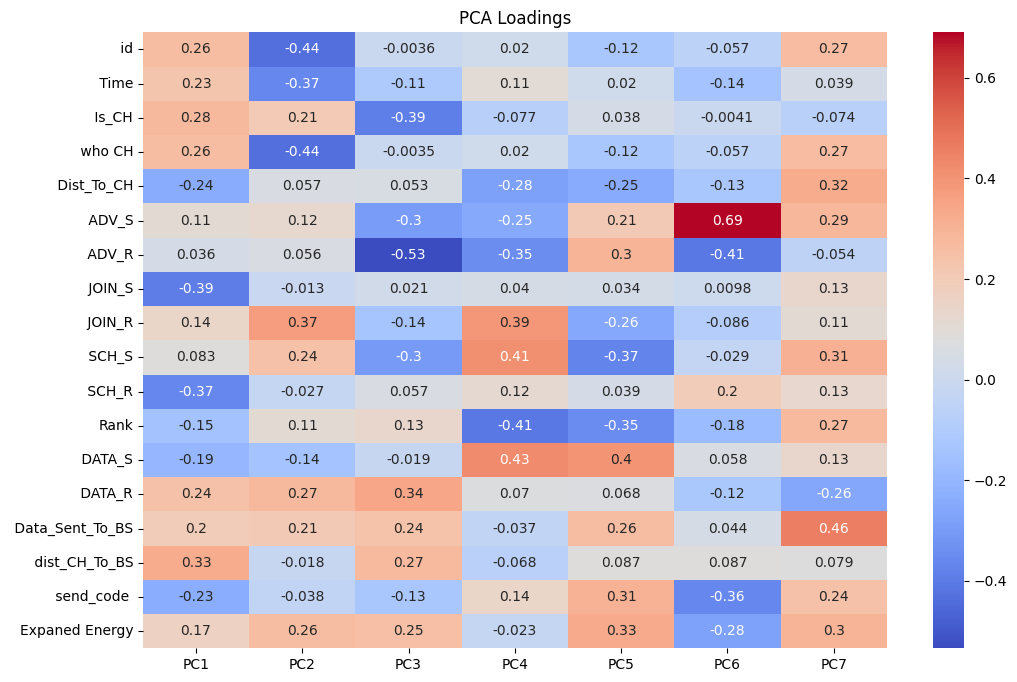

In [ ]:
import seaborn as sns
loadings = pd.DataFrame(model.components_.T, columns=[f'PC{i+1}' for i in range(n_pcs)], index=initial_feature_names)

plt.figure(figsize=(12, 8))
sns.heatmap(loadings, annot=True, cmap='coolwarm')
plt.title('PCA Loadings')
plt.show()

##visualising the top 6 columns in a parallel coordinates by taking 50 points in it

In [ ]:
req_df=df[most_important_names]
req_df.dtypes
req_float = req_df.astype(float)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
import random

In [ ]:
original_df=pd.read_csv("WSN-DS.csv")

In [ ]:
attack_type=original_df["Attack type"]
attack_type=pd.DataFrame(attack_type)

In [ ]:
tdma_indices=original_df.loc[original_df["Attack type"]=="TDMA"].index.tolist()
flood_indices=original_df.loc[original_df["Attack type"]=="Flooding"].index.tolist()
bhole_indices=original_df.loc[original_df["Attack type"]=="Blackhole"].index.tolist()
grhole_indices=original_df.loc[original_df["Attack type"]=="Grayhole"].index.tolist()
normal_indices=original_df.loc[original_df["Attack type"]=="Normal"].index.tolist()

In [ ]:
np.random.seed(42)
num_points=500
l=len(df)
print(f"l {l}")
points_per_category=num_points//5
flood_chunks=np.random.choice(flood_indices,points_per_category,replace=False)
tdma_chunks=np.random.choice(tdma_indices,points_per_category,replace=False)
bhole_chunks=np.random.choice(bhole_indices,points_per_category,replace=False)
grhole_chunks=np.random.choice(grhole_indices,points_per_category,replace=False)
normal_chunks=np.random.choice(normal_indices,points_per_category,replace=False)

random_indices=np.concatenate([flood_chunks,tdma_chunks,bhole_chunks,grhole_chunks,normal_chunks])


l 374661


In [ ]:
#choosing random 50 points to become one with the data
"""random_indices = np.random.choice(num_points, num_points, replace=False)
random_indices = np.random.choice(l, size=num_elements, replace=False)
random_indices = np.random.randint(1, num_points, size=l)
"""
ys=req_df.iloc[random_indices]
print(f"ys",ys)
category=original_df["Attack type"][random_indices].to_numpy()
ys=ys.to_numpy()


ys          ADV_S   ADV_R      id   JOIN_S   DATA_S   Data_Sent_To_BS
5737         9      27  201069        0        0                13
14110       19      28  304054        0        0                13
25703        7      28  302001        0        0                13
24880       10      17  106027        0        0               160
7053        18      28  602034        0        0                13
...        ...     ...     ...      ...      ...               ...
24447        0      27  101094        1       22                 0
280198       0       6  116025        1       32                 0
92054        0       3  303079        1       51                 0
96498        0       4  215016        1       53                 0
1182         0       6  112082        1       51                 0

[500 rows x 6 columns]


In [ ]:
num_points

500

In [ ]:
feat_no={"Normal":1,"TDMA":2,"Blackhole":3,"Grayhole":4,"Flooding":5}

In [ ]:
#normalising the data
ymins = ys.min(axis=0).astype(float)
ymaxs = ys.max(axis=0).astype(float)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs.shape

(500, 6)

In [ ]:
set(category)

{'Blackhole', 'Flooding', 'Grayhole', 'Normal', 'TDMA'}

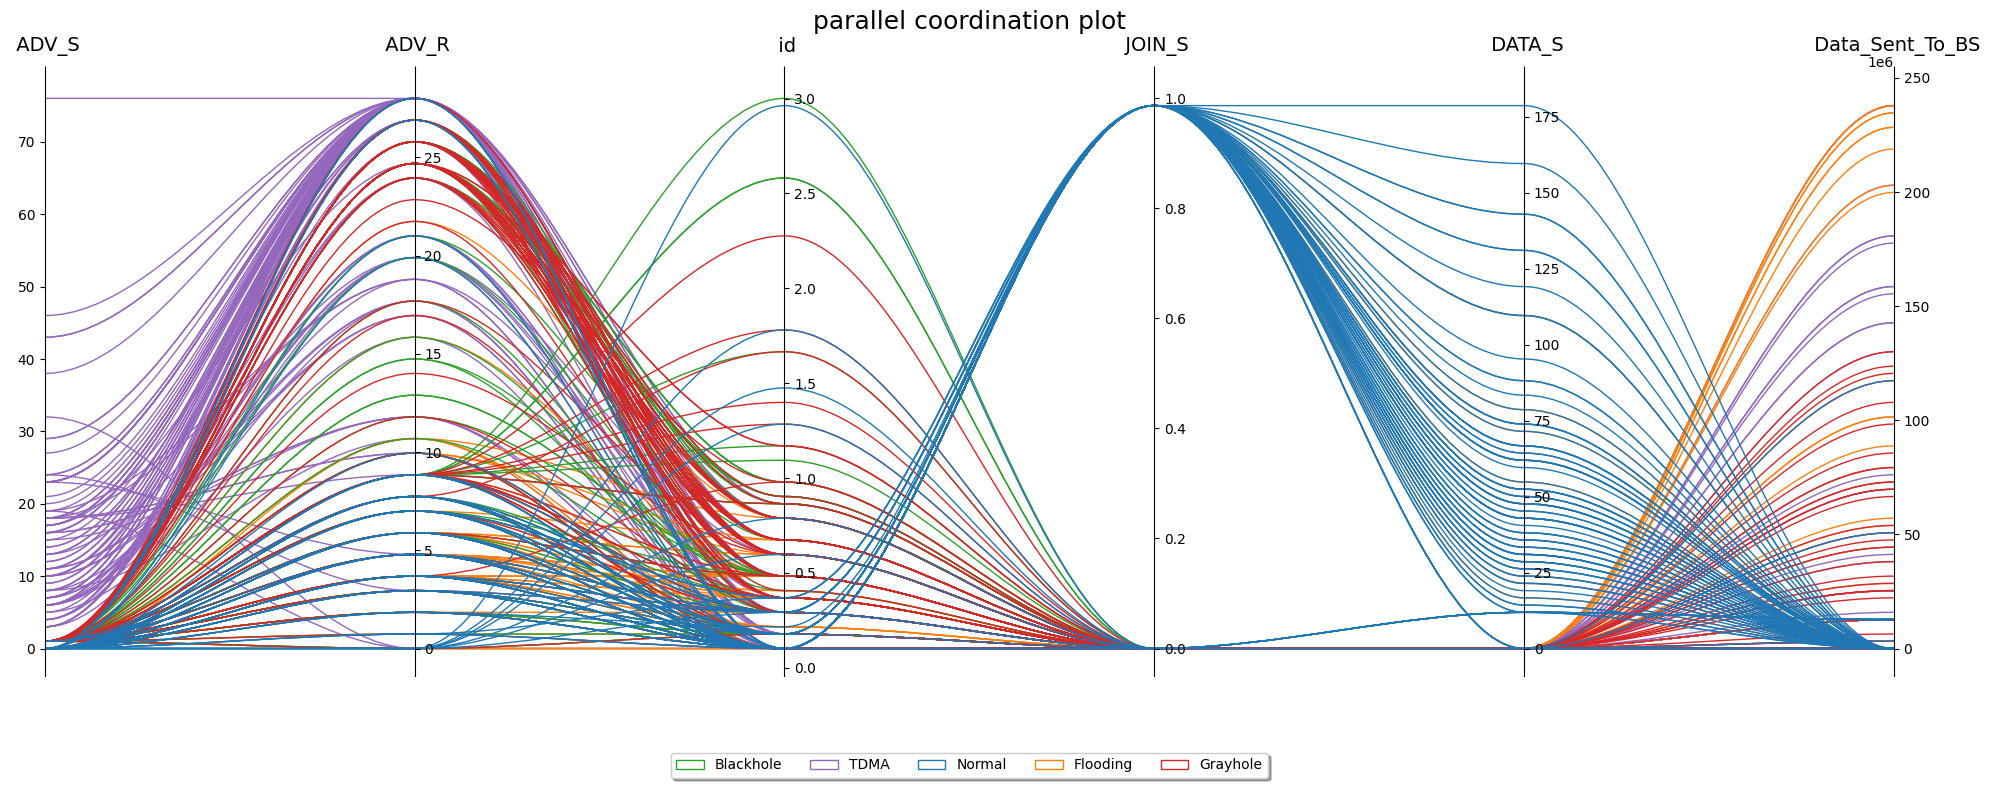

In [ ]:
/*
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

fig, host = plt.subplots(figsize=(20,8))

axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))
title="parallel coordination plot"
host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(most_important_names,fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
host.set_title('Parallel Coordinates Plot', fontsize=18)
host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(most_important_names, fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
host.set_title(title, fontsize=18)

legend_handles = [None for _ in category]

colors = plt.cm.tab10.colors
for j in range(0,num_points):
    # to just draw straight lines between the axes:
    #host.plot(range(ys.shape[1]), zs[j,:], c=colors[(dictionary[category[j]] - 1) % len(colors) ])

    # create bezier curves
    # for each axis, there will a control vertex at the point itself, one at 1/3rd towards the previous and one
    #   at one third towards the next axis; the first and last axis have one less control vertex
    # x-coordinate of the control vertices: at each integer (for the axes) and two inbetween
    # y-coordinate: repeat every point three times, except the first and last only twice
    verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],np.repeat(zs[j, :], 3)[1:-1]))
    # for x,y in verts: host.plot(x, y, 'go') # to show the control points of the beziers
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=1, edgecolor=colors[feat_no[category[j]]-1])
    legend_handles[feat_no[category[j]]] = patch
    host.add_patch(patch)
host.legend( set(legend_handles),set(category),
            loc='lower center', bbox_to_anchor=(0.5, -0.18),
            ncol=len(category), fancybox=True, shadow=True)

plt.tight_layout()
plt.show()
*/

#Creating the model

In [ ]:
# CNN_LSTM model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.tile(x, [1, 1, 3]), input_shape=(18, 1)),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='valid'),
        tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='valid'),
        tf.keras.layers.LSTM(70),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return model

In [ ]:
model1=create_model()

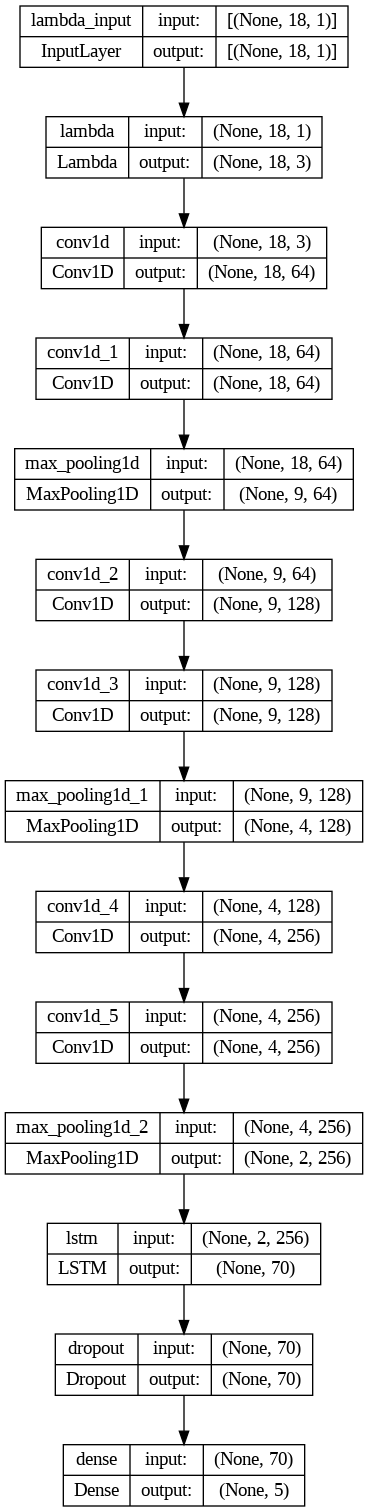

In [ ]:
from keras.utils import plot_model
plot_model(model1,show_shapes=True,to_file="cnn_model.png")

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 18, 3)             0         
                                                                 
 conv1d (Conv1D)             (None, 18, 64)            640       
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 64)             0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 9, 128)            24704     
                                                                 
 conv1d_3 (Conv1D)           (None, 9, 128)            49280     
                                                        

In [ ]:
#model1.fit(X_train_reshaped,y_train,epochs=1,batch_size=1000,validation_data=(X_test_reshaped,y_test))

In [ ]:
#evaluation_result=model1.evaluate(X_test_reshaped,y_test)

In [ ]:
#evaluation_result[2]

In [ ]:
def create_tf_dataset_for_client(data):
    return tf.data.Dataset.from_tensor_slices(data).batch(1000)

'''

this function takes data tuple(features and lables), convert them into tf dataset and
batches them into mini batches of 20 per batch
'''

'\n\nthis function takes data tuple(features and lables), convert them into tf dataset and\nbatches them into mini batches of 20 per batch\n'

In [ ]:
# Federated Data Preparation
NUM_CLIENTS = 10
client_data = []
for i in range(NUM_CLIENTS):
    start_index = i * (len(X_train_reshaped) // NUM_CLIENTS)
    end_index = (i + 1) * (len(X_train_reshaped) // NUM_CLIENTS)
    client_data.append((X_train_reshaped[start_index:end_index], y_train[start_index:end_index]))
'''
splits the training data among multiple clients to simulate a federated learning senario.
'''

federated_train_data = [create_tf_dataset_for_client((client[0], client[1])) for client in client_data]
''' federated_train_data calls create_tf_dataset_for_client function.
    (client[0], client[1]) is a pair (features,lable)
  '''


' federated_train_data calls create_tf_dataset_for_client function.\n    (client[0], client[1]) is a pair (features,lable)\n  '

In [ ]:
len(X_train)

299728

In [ ]:
chunk_size = 10000

# Split the DataFrame into chunks of chunk_size rows each
chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
num_random=10
chunks[0]
import random

random_sample=random.sample(chunks,num_random)
len(random_sample)

10

In [ ]:
# Federated Data Preparation
NUM_CLIENTS = [10,12,15]
client_data = []
chunk_sizes=[10000,15000,18000]
def create_client_data(num_clients,chunk_size):
  # Split the DataFrame into chunks of chunk_size rows each
  X_train_chunks = [X_train_reshaped[i:i + chunk_size] for i in range(0, len(X_train_reshaped), chunk_size)]
  y_train_chunks= [y_train[i:i + chunk_size] for i in range(0, len(y_train), chunk_size)]
  #exacting the dataframe that have the exact no of chunk size
  X_train_chunks_exact=[X_train_chunks[i] for i in range(len(X_train_chunks)) if len(X_train_chunks[i])==chunk_size]
  y_train_chunks_exact=[y_train_chunks[i] for i in range(len(y_train_chunks)) if len(y_train_chunks[i])==chunk_size]
  #selecting random chunks of the num_clients  from the given chunks
  X_train_req_chunks=random.sample(X_train_chunks_exact, num_clients)
  y_train_req_chunks=random.sample(y_train_chunks_exact,num_clients)
  # Create a list of tuples
  client_data = [(X_train_req_chunks[i], y_train_req_chunks[i]) for i in range(num_clients)]
  return client_data
'''
splits the training data among multiple clients to simulate a federated learning senario.
'''
client_data_10clients_10000chunk=create_client_data(10,10000)
federated_train_data = [create_tf_dataset_for_client((client[0], client[1])) for client in client_data_10clients_10000chunk]
''' federated_train_data calls create_tf_dataset_for_client function.
    (client[0], client[1]) is a pair (features,lable)
  '''

' federated_train_data calls create_tf_dataset_for_client function.\n    (client[0], client[1]) is a pair (features,lable)\n  '

#extra try to increase the speed

In [ ]:
#finding the dataset type
#tf_dataset_type=tff.SequenceType(tff.types.tensorflow_to_type(federated_train_data[0].element_spec))

In [ ]:
client_learning_rate = 0.05
server_learning_rate = 0.1

client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=client_learning_rate)
server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=server_learning_rate)


In [ ]:
total_eval={}

def model_fn():
    keras_model = create_model()
    return tff.learning.models.from_keras_model(
        keras_model=keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),]
    )
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=client_optimizer_fn,
    server_optimizer_fn=server_optimizer_fn
)


In [ ]:
# Run federated training
NUM_CLIENTS = [10,12,15]
chunk_sizes=[10000,15000,18000]
NUM_ROUNDS =12
for client in NUM_CLIENTS :
  chunk_eval={}
  for chunk in chunk_sizes:
    client_data=create_client_data(client,chunk)
    federated_train_data = [create_tf_dataset_for_client((client[0], client[1])) for client in client_data]
    round_eval={}     # Initialize the process
    state = iterative_process.initialize()
    for round_num in range(NUM_ROUNDS):
        state, metrics = iterative_process.next(state, federated_train_data)
        print(f'Round {round_num}, Metrics: {metrics}')
        round_eval[round_num]=metrics["client_work"]["train"]
    chunk_eval[chunk]=round_eval
  total_eval[client]=chunk_eval

NameError: name 'create_client_data' is not defined

In [ ]:
def model_fn():
    keras_model = create_model()
    return tff.learning.models.from_keras_model(
        keras_model=keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(),
                 tf.keras.metrics.Precision(),
                 tf.keras.metrics.Recall()]
    )
fed_sgd = tff.learning.algorithms.build_fed_sgd(
    model_fn=model_fn,
    server_optimizer_fn=server_optimizer_fn
)


# Initialize the process


In [ ]:
NUM_CLIENTS = [10,12,15]
chunk_sizes=[10000,15000,18000]
NUM_ROUNDS =12
for client in NUM_CLIENTS :
  chunk_eval={}
  for chunk in chunk_sizes:
    client_data=create_client_data(client,chunk)
    federated_train_data = [create_tf_dataset_for_client((client[0], client[1])) for client in client_data]
    round_eval={}     # Initialize the process
    state = fed_sgd.initialize()
    for round_num in range(NUM_ROUNDS):
        state, metrics = fed_sgd.next(state, federated_train_data)
        print(f'Round {round_num}, Metrics: {metrics}')
        round_eval[round_num]=metrics["client_work"]["train"]
    chunk_eval[chunk]=round_eval
  total_eval[client]=chunk_eval

#Visualising the metrics

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting data for plotting
num_rounds = 12

# Prepare dictionaries to hold metric values for each round, client count, and chunk size
metrics_by_clients = {
    "accuracy": {client: [] for client in NUM_CLIENTS},
    "precision": {client: [] for client in NUM_CLIENTS},
    "recall": {client: [] for client in NUM_CLIENTS},
}

metrics_by_chunk_sizes = {
    "accuracy": {chunk: [] for chunk in chunk_sizes},
    "precision": {chunk: [] for chunk in chunk_sizes},
    "recall": {chunk: [] for chunk in chunk_sizes},
}

# Iterate through the evaluations and collect metrics
for client in NUM_CLIENTS:
    for chunk in chunk_sizes:
        round_metrics = total_eval[client][chunk]
        for round_num in range(num_rounds):
            metrics = round_metrics[round_num]
            accuracy = metrics['categorical_accuracy']
            precision = metrics['precision']
            recall = metrics['recall']

            metrics_by_clients["accuracy"][client].append(accuracy)
            metrics_by_clients["precision"][client].append(precision)
            metrics_by_clients["recall"][client].append(recall)

            metrics_by_chunk_sizes["accuracy"][chunk].append(accuracy)
            metrics_by_chunk_sizes["precision"][chunk].append(precision)
            metrics_by_chunk_sizes["recall"][chunk].append(recall)

In [ ]:
# Function to plot metrics
def plot_metric(metric_data, x_label, y_label, title, labels, x_ticks, save_as=None):
    plt.figure(figsize=(10, 6))
    for label in labels:
        plt.plot(range(1, len(metric_data[label]) + 1), metric_data[label], label=f'{label} {x_label}')

    plt.xlabel('Rounds')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(range(1, num_rounds + 1), x_ticks)
    plt.legend(loc='lower right')
    plt.grid(True)
    if save_as:
        plt.savefig(save_as)
    plt.show()

# Plotting metrics by number of clients
plot_metric(metrics_by_clients['accuracy'], 'Clients', 'Accuracy', 'Accuracy by Number of Clients', NUM_CLIENTS, range(1, num_rounds + 1))
plot_metric(metrics_by_clients['precision'], 'Clients', 'Precision', 'Precision by Number of Clients', NUM_CLIENTS, range(1, num_rounds + 1))
plot_metric(metrics_by_clients['recall'], 'Clients', 'Recall', 'Recall by Number of Clients', NUM_CLIENTS, range(1, num_rounds + 1))

In [ ]:
# Plotting metrics by chunk size
plot_metric(metrics_by_chunk_sizes['accuracy'], 'Chunk Size', 'Accuracy', 'Accuracy by Chunk Size', chunk_sizes, range(1, num_rounds + 1))
plot_metric(metrics_by_chunk_sizes['precision'], 'Chunk Size', 'Precision', 'Precision by Chunk Size', chunk_sizes, range(1, num_rounds + 1))
plot_metric(metrics_by_chunk_sizes['recall'], 'Chunk Size', 'Recall', 'Recall by Chunk Size', chunk_sizes, range(1, num_rounds + 1))

#visualising the performance of clients and dataset


In [ ]:
#keeping the no of clients safe and then evaluating dataset size over the epochs
no_client=15
chunk_metrics={}
for j in chunk_sizes:
  chunk_accuracy=[]
  chunk_precision=[]
  chunk_recall=[]
  for i in range(0,12):
    chunk_accuracy.append(accuracy[(no_client,j)][i])
    chunk_precision.append(precision[(no_client,j)][i])
    chunk_recall.append(recall[(no_client,j)][i])
  chunk_metrics[j]=(chunk_accuracy,chunk_precision,chunk_recall)
chunk_metrics=pd.DataFrame(chunk_metrics,columns=['accuracy', 'precision', 'recall'])

In [ ]:
chunk_metrics=chunk_metrics.transpose()
chunk_metrics

In [ ]:
plt_df=pd.DataFrame(total_eval)
plt_df

#working function for fedsgd

In [ ]:
# Client Work Function for FedSGD
@tff.tf_computation
def client_work(model_weights, dataset):
    model = create_model()
    model.set_weights(model_weights)

    @tf.function
    def compute_gradients(batch):
        with tf.GradientTape() as tape:
            outputs = model(batch[0], training=True)
            loss = tf.keras.losses.categorical_crossentropy(batch[1], outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        return gradients

    gradients = []
    for batch in dataset:
        batch_gradients = compute_gradients(batch)
        gradients.append(batch_gradients)

    return gradients


In [ ]:
# Server Side Logic
@tff.tf_computation
def server_update(model_weights, averaged_gradients):
    model = create_model()
    model.set_weights(model_weights)

    optimizer = tf.keras.optimizers.SGD(learning_rate=server_learning_rate)

    @tf.function
    def apply_gradients(gradients):
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return model.get_weights()

    averaged_gradients = [tf.reduce_mean(g, axis=0) for g in zip(*averaged_gradients)]
    new_weights = apply_gradients(averaged_gradients)

    return new_weights

In [ ]:
client_learning_rate = 0.01
server_learning_rate = 0.1

client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=client_learning_rate)
server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=server_learning_rate)


In [ ]:
def model_fn():
    keras_model = create_model()
    return tff.learning.models.from_keras_model(
        keras_model=keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(),
                 tf.keras.metrics.Precision(),
                 tf.keras.metrics.Recall()]
    )
iterative_process = tff.learning.algorithms.build_fed_sgd(
    model_fn=model_fn,
    server_optimizer_fn=server_optimizer_fn
)


In [ ]:
# Initialize the process
state = iterative_process.initialize()


In [ ]:
# Run federated training
NUM_ROUNDS = 10
for round_num in range(NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f'Round {round_num}, Metrics: {metrics}')

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Predict on test data
model.set_weights(state.model.trainable)
y_pred = model.predict(X_test_reshaped)

# Confusion Matrix
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test.values.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
def create_tf_dataset_for_client(data):
    return tf.data.Dataset.from_tensor_slices(data).batch(20)
NUM_CLIENTS = 5
client_data = []
for i in range(NUM_CLIENTS):
    start_index = i * (len(X_train_reshaped) // NUM_CLIENTS)
    end_index = (i + 1) * (len(X_train_reshaped) // NUM_CLIENTS)
    client_data.append((X_train_reshaped[start_index:end_index], y_train[start_index:end_index]))

federated_train_data = [create_tf_dataset_for_client((client[0], client[1])) for client in client_data]


@tff.tf_computation
def client_work(model_weights, dataset):
    model = create_model()
    model.set_weights(model_weights)

    @tf.function
    def compute_gradients(batch):
        with tf.GradientTape() as tape:
            outputs = model(batch[0], training=True)
            loss = tf.keras.losses.categorical_crossentropy(batch[1], outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        return gradients

    gradients = []
    for batch in dataset:
        batch_gradients = compute_gradients(batch)
        gradients.append(batch_gradients)

    return gradients

@tff.tf_computation
def server_update(model_weights, averaged_gradients):
    model = create_model()
    model.set_weights(model_weights)

    optimizer = tf.keras.optimizers.SGD(learning_rate=server_learning_rate)

    @tf.function
    def apply_gradients(gradients):
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return model.get_weights()

    averaged_gradients = [tf.reduce_mean(g, axis=0) for g in zip(*averaged_gradients)]
    new_weights = apply_gradients(averaged_gradients)

    return new_weights

client_learning_rate = 0.01
server_learning_rate = 0.1

client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=client_learning_rate)
server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=server_learning_rate)

def model_fn():
    keras_model = create_model()
    return tff.learning.models.from_keras_model(
        keras_model=keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(),
                 tf.keras.metrics.Precision(),
                 tf.keras.metrics.Recall()]
    )
iterative_process = tff.learning.algorithms.build_fed_sgd(
    model_fn=model_fn,
    server_optimizer_fn=server_optimizer_fn
)


# Initialize the process
state = iterative_process.initialize()

# Run federated training
NUM_ROUNDS = 10
for round_num in range(NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f'Round {round_num}, Metrics: {metrics}')